In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

from sklearn.preprocessing import StandardScaler

import numpy as np

from einops import rearrange, repeat

import matplotlib.pyplot as plt

import sys
from datetime import datetime as dt

# Models

## Transformer

In [2]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, d_hid, heads):
        super().__init__()
        self.d_hid = d_hid
        self.heads = heads
        self.dim_per_head = self.d_hid // self.heads
        
        self.qkv = nn.Linear(d_emb, self.d_hid * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.d_hid, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        q = qkv[..., :self.d_hid]
        k = qkv[..., self.d_hid : self.d_hid * 2]
        v = qkv[..., self.d_hid * 2 :]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
                
        return self.unifyheads(scores)

In [3]:
# class Embedder(nn.Module):
#     def __init__(self, vocab_size, d_emb, seq_length, emb_drop):
#         super().__init__()
#         self.embed = nn.Embedding(vocab_size, d_emb)
#         self.d_emb = d_emb
#         self.sr_d_emb = np.sqrt(d_emb)
#         self.dropout = nn.Dropout(emb_drop)
#         self.seq_length = seq_length
        
#         self.pe = nn.Parameter(torch.rand(seq_length, d_emb))
    
#     def forward(self, x):
#         # make embeddings relatively larger
#         x = self.embed(x) * self.sr_d_emb
#         x = x + self.pe[:x.size(1)]
#         x = self.dropout(x)
#         return x

In [4]:
class GLU(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size
        self.linear = nn.Linear(in_size, out_size * 2)
    def forward(self, x):
        x = self.linear(x)
        #x = x[..., : self.out_size] * x[..., self.out_size :].sigmoid()
        x = torch.einsum('...i, ...i->...i', [x[..., : self.out_size], x[..., self.out_size :].sigmoid()])
        return x

In [5]:
class Encoder_layer(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, enc_drop):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, d_hid, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        #self.ff = GLU(d_emb, d_emb)
        
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [6]:
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        
        d_emb, hidden_mult, order, enc_drop, lr = model_hp
        self.d_emb = d_emb
        
        d_score = 1
        d_barrier = 4
        seq_length = 5
        
        # self.score_emb = GLU(d_score, d_score * d_emb)
        # self.temp_score_emb = GLU(1, d_emb)
        self.score_emb = nn.Linear(1, d_emb)
        self.temp_score_emb = nn.Linear(1, d_emb)
        self.dice_emb = nn.Embedding(6, d_emb)
        self.barrier_emb = nn.Embedding(d_barrier, d_emb)
        
        self.sr_d_emb = np.sqrt(d_emb)
        
        self.cls_token = nn.Parameter(torch.rand(1, d_emb))
        self.pe = nn.Parameter(torch.rand(seq_length, d_emb))
                
        self.encoder = nn.ModuleList()
        for d_hid, heads in order:
            self.encoder.append(Encoder_layer(d_emb, d_hid, hidden_mult, heads, enc_drop))
        
        #self.out = GLU(self.d_emb, 2)
        self.out = nn.Sequential(
            nn.Linear(self.d_emb, self.d_emb * 2),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(self.d_emb * 2, 2)
        )
                
        #self.weights_init()
        
        self.optimizer = torch.optim.AdamW(self.parameters(), lr = lr)
        self.criterion = nn.CrossEntropyLoss()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        # if torch.cuda.is_available():
        #     torch.cuda.set_device(cuda)
        #     self.device = torch.device('cuda')
        # else:
        #     self.device = torch.device('cpu')
        self.to(self.device)
        
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                #nn.init.xavier_uniform_(m.weight)
                nn.init.normal_(m.weight, mean = 0, std = 0.01)
                #m.bias.data.fill_(0.01)
         
    def forward(self, s, ts, d, b):
        s = self.score_emb(s)
        s = rearrange(s, '... (s e) -> ... s e', e = self.d_emb)
        ts = self.temp_score_emb(ts)#[None]
        ts = rearrange(ts, '... (s e) -> ... s e', e = self.d_emb)
        d = self.dice_emb(d)
        b = self.barrier_emb(b)
        
        x = torch.cat((s, ts, d, b), dim = -2)
        
        cls_toks = repeat(self.cls_token, 's e -> b s e', b = x.size(0))
        x = torch.cat((cls_toks, x), dim = 1)
        x = x * self.sr_d_emb + self.pe #[:x.size(1)]
        print(x.shape)
        for enc in self.encoder:
            x = enc(x)
        x = x[:, 0]
        out = self.out(x)
        return out

In [ ]:
model = Transformer(model_hp)

In [ ]:
for x, y in train_loader:
    x = x.to(model.device)
    out = model(x[:, 0:1].float(), x[:, 1:2].float(), x[:, 2:3].long(), x[:, 3:4].long())
    break

## Training

In [7]:
def train_eval(model, train_loader, epochs):
    start_time = dt.now()
    loss_train = []
    for ep in range(1, epochs + 1):
        model.train()
        loss_tempo = []
        for x, y in train_loader:
            x = x.to(model.device)
            y = y.to(model.device)
            out = model(x[:, 0:1].float(), x[:, 1:2].float(), x[:, 2:3].long(), x[:, 3:4].long())
            loss = model.criterion(out, y.long())
            model.optimizer.zero_grad()
            loss.backward()
            model.optimizer.step()
            loss_tempo.append(loss.item())
        loss_t = np.mean(np.asarray(loss_tempo), axis=0)
        loss_train.append(loss_t)
        model.epochs += 1
        model.losses.append(loss_t)
              
        # model.eval()
        # with torch.no_grad():
        #     loss_tempo = []
        #     for x, y in val_loader:
        #         x = x.to(device)
        #         y = y.to(device)
        #         out = model(x.float())
        #         loss = model.criterion(out, y.long())
        #         loss_tempo.append(loss.item())
        #     #loss_val.append(np.mean(np.asarray(loss_tempo), axis=0))
        # loss_v = np.mean(np.asarray(loss_tempo), axis=0)
        # loss_val.append(loss_v)
        
        elapsed = dt.now() - start_time
        secs = elapsed.seconds
        ratio = ep / epochs
        printout = '\r[%-16s] %d%%, epoch: %d/%d, %02d:%02d:%02d:%02d, loss: %f'
        sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), ep, epochs, 
                                     elapsed.days, secs // 3600, secs // 60 % 60, secs % 60, loss_t))
        sys.stdout.flush()
        
    sys.stdout.write('\n')
    return loss_train

# Agent

In [8]:
class Agent():
    def __init__(self, model_hp):
        super().__init__()
        self.net = Transformer(model_hp)
        
        self.age = 0
        self.replay_history = []
        self.turns_history = []
        
        self.history = []
        self.me_score = 0
        self.n_dice = 5
        self.barrier = 0
        self.roll = []
        self.tempo_score = 0
        self.n_turns = 0
    
    def end_game(self, flag):
        if flag:
            self.replay_history.append(self.history)
            self.turns_history.append(self.n_turns)
        self.history = []
        self.me_score = 0
        self.n_dice = 5
        self.barrier = 0
        self.roll = []
        self.tempo_score = 0
        self.n_turns = 0

In [9]:
def make_roll(agent):
    agent.roll = np.random.randint(6, size = agent.n_dice)
    count = np.unique(agent.roll, return_counts = True)
    summ = 0
    for d, c in zip(count[0], count[1]):
        if c == 5:
            if d == 0:
                summ += 400
            elif d == 4:
                summ += 200
            else:
                summ += 120
            agent.n_dice = agent.n_dice - c
        elif c == 4:
            if d == 0:
                summ += 200
            elif d == 4:
                summ += 100
            else:
                summ += 60
            agent.n_dice = agent.n_dice - c
        elif c == 3:
            if d == 0:
                summ += 100
            elif d == 4:
                summ += 50
            else:
                summ += 30
            agent.n_dice = agent.n_dice - c
        else:
            if d == 0:
                summ += 10 * c
                agent.n_dice = agent.n_dice - c
            elif d == 4:
                summ += 5 * c
                agent.n_dice = agent.n_dice - c
        if agent.n_dice == 0:
            agent.n_dice = 5
            break
    if summ == 0:
        agent.tempo_score = 0
        return False
    else:
        agent.tempo_score = agent.tempo_score + summ
        return True

In [10]:
def turn(agent, epsilon):
    while True:
        flag = make_roll(agent)
        if flag:
            score = agent.me_score + agent.tempo_score
            if score >= 1000:
                break
            if (score > 395 and score < 500) or (score > 895 and score < 1000):
                if agent.barrier == 0:
                    agent.barrier = 1
                elif agent.barrier == 2:
                    continue
            else:
                if agent.barrier == 2:
                    agent.barrier = 3
                else:
                    agent.barrier = 0
            s0 = agent.me_score / 1000
            ts0 = agent.tempo_score / 1000
            d0 = agent.n_dice
            b0 = agent.barrier
            if np.random.rand() < epsilon:
                action = np.random.choice([0, 1])
            else:
                s = torch.tensor([[s0]], dtype = torch.float, device = agent.net.device)
                ts = torch.tensor([[ts0]], dtype = torch.float, device = agent.net.device)
                d = torch.tensor([[d0]], dtype = torch.long, device = agent.net.device)
                b = torch.tensor([[b0]], dtype = torch.long, device = agent.net.device)
                out = agent.net(s, ts, d, b)
                action = torch.argmax(out).item()
            agent.history.append([s0, ts0, d0, b0, action])
            if action:
                continue
            else:
                break
        else:
            break
    agent.me_score = agent.me_score + agent.tempo_score
    agent.tempo_score = 0
    agent.n_dice = 5
    if (agent.me_score > 395 and agent.me_score < 500) or (agent.me_score > 895 and agent.me_score < 1000):
        agent.barrier = 2
    else:
        agent.barrier = 0
    agent.n_turns = agent.n_turns + 1

In [11]:
def game(agent, epsilon, max_turns = 100):
    while True:
        turn(agent, epsilon)
        if agent.me_score >= 1000:
            agent.end_game(True)
            break
        if agent.n_turns == max_turns:
            agent.end_game(False)
            break

In [12]:
def last_game_history(agent):
    for h in agent.history:
        if len(h) == 1:
            print('score:', h[0])
        elif len(h) == 3:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2])
        elif len(h) == 4:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2], 'barrier:', h[3])
        else:
            print('score:', h[0], 'roll:', h[1] + 1, 't-score:', h[2], 'barrier:', h[3], 'action:', h[4])
    print('turns:', agent.n_turns)

# Create Agent

In [13]:
d_emb = 8
#seq_length = 6
hidden_mult = 4
# order = [(128, 8), (128, 8), 
#          (64, 4), (64, 4), 
#          (64, 2), (64, 2), 
#          (32, 1), (32, 1)]
order = [(32, 4), (32, 4), (32, 2), (32, 2), (32, 1), (32, 1)]
#heads_order = [1] * 12
enc_drop = 0.05  # 0.005
lr = 0.001

In [14]:
model_hp = d_emb, hidden_mult, order, enc_drop, lr

In [15]:
agent = Agent(model_hp)
print('num of parameters:', sum(p.numel() for p in agent.net.parameters() if p.requires_grad))

num of parameters: 10034


## collect data

In [16]:
n_games = 100
epsilon = 1

In [17]:
start_time = dt.now()
for i in range(n_games):
    game(agent, epsilon)
    elapsed = dt.now() - start_time
    secs = elapsed.seconds
    ratio = (i + 1) / n_games
    printout = '\r[%-16s] %d%%, %d, %02d:%02d:%02d:%02d'
    sys.stdout.write(printout % ('='*round(16 * ratio), round(100 * ratio), (i + 1), elapsed.days, secs // 3600, 
                                 secs // 60 % 60, secs % 60))
    sys.stdout.flush()

[================] 100%, 100, 00:00:00:01

In [18]:
turns = np.asarray(agent.turns_history)

In [19]:
turns.shape

(99,)

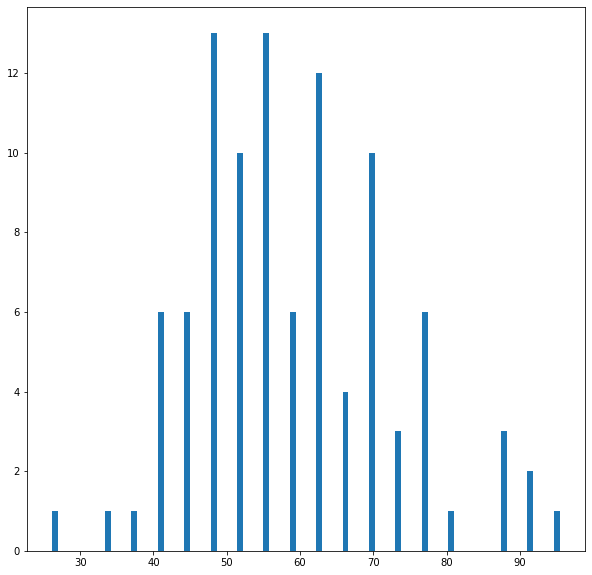

In [20]:
hist, bins = np.histogram(turns, bins = 20)
plt.figure(figsize = (10, 10))
plt.bar(bins[1:], hist)
plt.show()

In [21]:
indices = np.argwhere(turns < 55)[:,0]

In [22]:
indices.shape

(45,)

In [23]:
raw_data = []
for i in indices:
    raw_data.append(agent.replay_history[i])

In [24]:
raw_data = np.vstack(raw_data)

In [25]:
raw_data.shape

(2421, 5)

In [26]:
flag_save = True

In [27]:
if flag_save:
    torch.save(raw_data, 'data/twsyacha/RL0/raw_data_0.np')

In [26]:
flag_load = True
file_name = 'raw_data_0.np'

In [27]:
if flag_load:
    raw_data = torch.load('data/twsyacha/RL0/' + file_name)

In [28]:
X_train, Y_train = raw_data[:, :-1], raw_data[:, -1]

## Train

In [29]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)

In [30]:
batch_size = 32

In [31]:
train_data = TensorDataset(torch.from_numpy(X_train_scaled), torch.from_numpy(Y_train))
train_loader = DataLoader(train_data, shuffle = True, batch_size = batch_size, drop_last = True)

In [32]:
epochs = 2**8
#agent.net = Transformer(model_hp)

In [ ]:
loss_train = train_eval(agent.net, train_loader, epochs)

total epochs 257


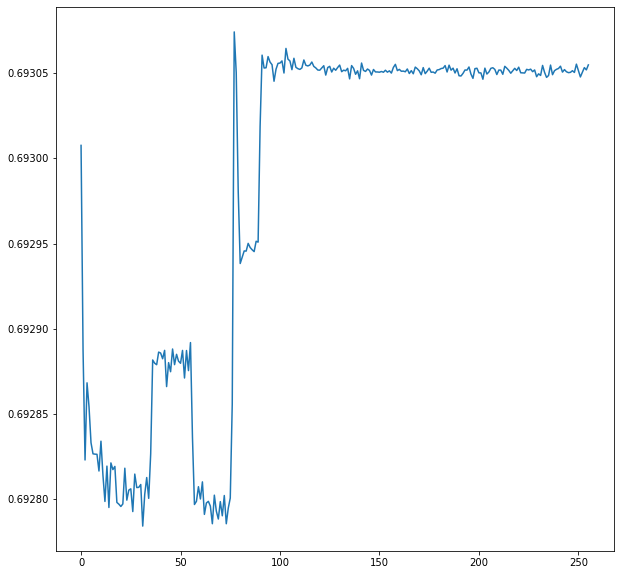

In [79]:
print('total epochs', agent.net.epochs)
plt.figure(figsize = (10, 10))
plt.plot(loss_train)
plt.show()

0 5


False

[3] 35 1


# WORKS

In [277]:
embs = nn.Embedding(3, 5)

In [ ]:
import torch
import torchga
import pygad

def fitness_func(solution, sol_idx):
    global data_inputs, data_outputs, torch_ga, model, loss_function

    model_weights_dict = torchga.model_weights_as_dict(model=model,
                                                         weights_vector=solution)

    # Use the current solution as the model parameters.
    model.load_state_dict(model_weights_dict)

    predictions = model(data_inputs)

    solution_fitness = 1.0 / (loss_function(predictions, data_outputs).detach().numpy() + 0.00000001)

    return solution_fitness

def callback_generation(ga_instance):
    print("Generation = {generation}".format(generation=ga_instance.generations_completed))
    print("Fitness    = {fitness}".format(fitness=ga_instance.best_solution()[1]))

# Create the PyTorch model.
input_layer  = torch.nn.Linear(2, 4)
relu_layer = torch.nn.ReLU()
dense_layer = torch.nn.Linear(4, 2)
output_layer = torch.nn.Softmax(1)

model = torch.nn.Sequential(input_layer,
                            relu_layer,
                            dense_layer,
                            output_layer)
# print(model)

# Create an instance of the pygad.torchga.TorchGA class to build the initial population.
torch_ga = torchga.TorchGA(model=model,
                           num_solutions=10)

loss_function = torch.nn.BCELoss()

# XOR problem inputs
data_inputs = torch.tensor([[0.0, 0.0],
                            [0.0, 1.0],
                            [1.0, 0.0],
                            [1.0, 1.0]])

# XOR problem outputs
data_outputs = torch.tensor([[1.0, 0.0],
                             [0.0, 1.0],
                             [0.0, 1.0],
                             [1.0, 0.0]])

# Prepare the PyGAD parameters. Check the documentation for more information: https://pygad.readthedocs.io/en/latest/README_pygad_ReadTheDocs.html#pygad-ga-class
num_generations = 250 # Number of generations.
num_parents_mating = 5 # Number of solutions to be selected as parents in the mating pool.
initial_population = torch_ga.population_weights # Initial population of network weights.

# Create an instance of the pygad.GA class
ga_instance = pygad.GA(num_generations=num_generations, 
                       num_parents_mating=num_parents_mating, 
                       initial_population=initial_population,
                       fitness_func=fitness_func,
                       on_generation=callback_generation)

# Start the genetic algorithm evolution.
ga_instance.run()

# After the generations complete, some plots are showed that summarize how the outputs/fitness values evolve over generations.
ga_instance.plot_fitness(title="PyGAD & PyTorch - Iteration vs. Fitness", linewidth=4)

# Returning the details of the best solution.
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))
print("Index of the best solution : {solution_idx}".format(solution_idx=solution_idx))

# Fetch the parameters of the best solution.
best_solution_weights = torchga.model_weights_as_dict(model=model,
                                                      weights_vector=solution)
model.load_state_dict(best_solution_weights)
predictions = model(data_inputs)
print("Predictions : \n", predictions.detach().numpy())

# Calculate the binary crossentropy for the trained model.
print("Binary Crossentropy : ", loss_function(predictions, data_outputs).detach().numpy())

# Calculate the classification accuracy of the trained model.
a = torch.max(predictions, axis=1)
b = torch.max(data_outputs, axis=1)
accuracy = torch.sum(a.indices == b.indices) / len(data_outputs)
print("Accuracy : ", accuracy.detach().numpy())

In [ ]:
def unflatten(flattened, shapes):
    newarray = []
    index = 0
    for shape in shapes:
        size = np.product(shape)
        newarray.append(flattened[index : index + size].reshape(shape))
        index += size
    return newarray
        
def crossover(agents, network, pop_size):
    offspring = []
    for _ in range((pop_size - len(agents)) // 2):
        parent1 = random.choice(agents)
        parent2 = random.choice(agents)
        child1 = Agent(network)
        child2 = Agent(network)

        shapes = [a.shape for a in parent1.neural_network.weights]

        genes1 = np.concatenate([a.flatten() for a in parent1.neural_network.weights])
        genes2 = np.concatenate([a.flatten() for a in parent2.neural_network.weights])

        split = random.randint(0,len(genes1)-1)child1_genes = np.array(genes1[0:split].tolist() + genes2[split:].tolist())
        child2_genes = np.array(genes1[0:split].tolist() + genes2[split:].tolist())

        child1.neural_network.weights = unflatten(child1_genes,shapes)
        child2.neural_network.weights = unflatten(child2_genes,shapes)

        offspring.append(child1)
        offspring.append(child2)
    agents.extend(offspring)
    return agents

In [161]:
#tempo = table_w > 1
#torch.nonzero(table_w > 1, as_tuple = True)
(table_w >= 0).nonzero(as_tuple = True)

(tensor([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
         18, 19, 20, 21, 22]),)

In [168]:
table_w

tensor([ 15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
        -15.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.])

In [171]:
tens = torch.randint(15, (24,))
tens

tensor([11,  1,  4,  6,  4,  0,  3, 10, 12,  9,  2,  5,  3,  7,  8,  3, 10,  5,
        12,  4, 13, 12,  8,  4])

In [176]:
inds = (tens > 11).nonzero().view(-1)
inds

tensor([ 8, 18, 20, 21])

In [179]:
ch_inds = torch.arange(16, 24)
ch_inds

tensor([16, 17, 18, 19, 20, 21, 22, 23])

In [177]:
inds[0] = 17
inds

tensor([17, 18, 20, 21])

In [182]:
torch.all(inds > 18)

tensor(False)

In [114]:
class Dice_embedder(nn.Module):
    def __init__(self, d_emb):
        super().__init__()
        self.embed = nn.Embedding(6, d_emb)
    
    def forward(self, x):
        x = self.embed(x)
        #x = rearrange(x, '... i j -> ... (i j)')
        return x

In [115]:
model = Dice_embedder(4)

In [162]:
roll = torch.randint(6, (2,))
roll

tensor([3, 4])

In [165]:
3 in roll

True

In [153]:
roll[1:2]

tensor([1])

In [132]:
result = model(roll[:1])
result

tensor([[ 1.5480, -0.9881,  0.6946, -1.4169]], grad_fn=<EmbeddingBackward0>)

In [127]:
tens = torch.zeros(5,)
tens

tensor([0., 0., 0., 0., 0.])

In [134]:
torch.cat((tens, result[0]))

tensor([ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  1.5480, -0.9881,  0.6946,
        -1.4169], grad_fn=<CatBackward0>)

In [45]:
class Multi_Head_Attention(nn.Module):
    def __init__(self, d_emb, d_hid, heads):
        super().__init__()
        self.d_hid = d_hid
        self.heads = heads
        self.dim_per_head = self.d_hid // self.heads
        
        self.qkv = nn.Linear(d_emb, self.d_hid * 3, bias = False)
        
        
        self.unifyheads = nn.Linear(self.d_hid, d_emb)
    
    def self_attention(self, q, k, v):
        scores = torch.einsum('...ij,...kj->...ik', q, k) / np.sqrt(self.dim_per_head)
        scores = F.softmax(scores, dim = -1)
        return torch.einsum('...ij,...jk->...ik', scores, v)
    
    def forward(self, x):
        qkv = self.qkv(x)
        q = qkv[..., :self.d_hid]
        k = qkv[..., self.d_hid : self.d_hid * 2]
        v = qkv[..., self.d_hid * 2 :]
            
        q = rearrange(q, '... i (h j) -> ... h i j', h = self.heads)
        k = rearrange(k, '... i (h j) -> ... h i j', h = self.heads)
        v = rearrange(v, '... i (h j) -> ... h i j', h = self.heads)
                
        scores = self.self_attention(q, k, v)
        scores = rearrange(scores, '... h i j -> ... i (h j)').contiguous()
                
        return self.unifyheads(scores)

In [46]:
class GLU(nn.Module):
    def __init__(self, in_size, out_size):
        super().__init__()
        self.out_size = out_size
        self.linear = nn.Linear(in_size, out_size * 2)
    def forward(self, x):
        x = self.linear(x)
        #x = x[..., : self.out_size] * x[..., self.out_size :].sigmoid()
        x = torch.einsum('...i, ...i->...i', [x[..., : self.out_size], x[..., self.out_size :].sigmoid()])

In [47]:
class Encoder_layer(nn.Module):
    def __init__(self, d_emb, d_hid, hidden_mult, heads, enc_drop):
        super().__init__()
        self.dropout = nn.Dropout(enc_drop)
        
        self.mha = Multi_Head_Attention(d_emb, d_hid, heads)
        self.norm_1 = nn.LayerNorm(d_emb)
        self.ff = nn.Sequential(
            nn.Linear(d_emb, hidden_mult * d_emb),
            #nn.ReLU(),
            #nn.GELU(),
            nn.LeakyReLU(),
            nn.Linear(hidden_mult * d_emb, d_emb)
        )
        #self.ff = GLU(d_emb, d_emb)
        
        self.norm_2 = nn.LayerNorm(d_emb)
        
    def forward(self, x):
        attended = self.mha(x)
        x = attended + x
        x = self.dropout(x)
        x = self.norm_1(x)
        fed_for = self.ff(x)
        x = fed_for + x
        x = self.dropout(x)
        x = self.norm_2(x)
        return x

In [ ]:
class Transformer(nn.Module):
    def __init__(self, model_hp):
        super().__init__()
        self.epochs = 0
        self.losses = []
        
        d_emb, seq_length, hidden_mult, order, enc_drop, lr, cuda = model_hp
        self.d_emb = d_emb
        
        self.score_emb = GLU(2, 2 * d_emb)
        self.dice_emb = nn.Embedding(6, d_emb)
        self.barrier_emb = nn.Embedding(2, d_emb)
        
        self.pe = nn.Parameter(torch.rand(seq_length + 1, d_emb))
        self.cls_token = nn.Parameter(torch.rand(1, d_emb))
        
        self.encoder = nn.ModuleList()
        for d_hid, heads in order:
            self.encoder.append(Encoder_layer(d_emb, d_hid, hidden_mult, heads, enc_drop))
        
        self.out = GLU(self.d_emb, 2)
                
        self.weights_init()
        
        self.optimizer = torch.optim.AdamW(self.parameters(), lr = lr)
        self.loss = nn.HuberLoss()
        if torch.cuda.is_available():
            torch.cuda.set_device(cuda)
            self.device = torch.device('cuda')
        else:
            self.device = torch.device('cpu')
        self.to(self.device)
        
    def weights_init(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                #m.bias.data.fill_(0.01)
         
    def forward(self, s, d, b):
        s = self.score_emb(s)
        s = rearrange(s, '... (s e) -> ... s e', e = self.d_emb)
        d = self.dice_emb(d)
        b = self.barrier_emb(b)
        
        x = torch.cat((s, d, b), dim = -2)
        
        cls_toks = repeat(self.cls_token, 's e -> b s e', b = x.size(0))
        x = torch.cat((cls_toks, x), dim = 1)
        x = x + self.pe #[:x.size(1)]
        for enc in self.encoder:
            x = enc(x)
        x = x[:, 0]
        out = self.out(x)
        return out

In [ ]:
GAMMA = 0.999
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 200
TARGET_UPDATE = 10

In [185]:
def get_reward(table, roll, action):
    reward = 0
    flag = False
    roll = roll + 1
    target = action + roll
    if table[action] < 1:
        reward -=2
    elif target > 23 or table[target] < 0:
        reward -= 1
    else:
        reward += table[action] / 6
        flag = True
    return reward, flag

def get_reward_end(table, roll, action):
    reward = 0
    flag = False
    roll = roll + 1
    target = action + roll
    if table[action] < 1:
        reward -= 2
    elif target > 23:
        reward += 1
        flag = True
    elif table[target] < 0:
        reward -= 1
    else:
        flag = True
    return reward, flag

In [ ]:
def turn(models, table, roll):
    reward = 0
    roll = torch.randint(6, (2,))
    d = roll.to(device)
    t = table.to(device)
    chosen_actions = []
    outs = []
    out = models[0](t, d)
    outs.append(out)
    choice = out.argsort()[::-1]
    for i, ch in enumerate(choice):
        out = models[i + 1](t, d[ch : ch + 1])
        spots = (table > 0).nonzero().view(-1)
        actions = out.argsort()[::-1]
        if torch.all(spots > 17):
            for a in actions:
                r, flag = get_reward_end(table, roll[choice], a)
                reward += r
                if flag:
                    break
            a = -1
        else:
            for a in actions:
                r, flag = get_reward(table, roll[choice], a)
                reward += r
                if flag:
                    break
            a = -1
        outs.append(out)
        chosen_actions.append(a)